In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, classification_report, roc_curve, auc
from imblearn.over_sampling import SMOTE

In [2]:
df = pd.read_csv("UCI_Credit_Card.csv")
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,0,2,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,0,0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,0,0,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,0,0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


Basic Data Analyses

In [3]:
df.shape

(30000, 25)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2                   300

In [5]:
df.isnull().sum()

ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default.payment.next.month    0
dtype: int64

In [6]:
df.duplicated().sum()

np.int64(0)

Exploratory Data Analyses - EDA

In [7]:
df = df.drop(columns=['ID'])

In [8]:
df.rename(columns={'default.payment.next.month': 'default'}, inplace=True)

In [9]:
print(df['EDUCATION'].value_counts(),"\n")

print(df['MARRIAGE'].value_counts(),"\n")

print(df['AGE'].value_counts())

EDUCATION
2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: count, dtype: int64 

MARRIAGE
2    15964
1    13659
3      323
0       54
Name: count, dtype: int64 

AGE
29    1605
27    1477
28    1409
30    1395
26    1256
31    1217
25    1186
34    1162
32    1158
33    1146
24    1127
35    1113
36    1108
37    1041
39     954
38     944
23     931
40     870
41     824
42     794
44     700
43     670
45     617
46     570
22     560
47     501
48     466
49     452
50     411
51     340
53     325
52     304
54     247
55     209
56     178
57     122
58     122
59      83
21      67
60      67
61      56
62      44
64      31
63      31
66      25
65      24
67      16
69      15
70      10
68       5
73       4
75       3
71       3
72       3
79       1
74       1
Name: count, dtype: int64


In [10]:
df['EDUCATION'] = df['EDUCATION'].replace([0, 5, 6], 4)

df['MARRIAGE'] = df['MARRIAGE'].replace([0], 3)

print(df['EDUCATION'].value_counts(),"\n")
print(df['MARRIAGE'].value_counts())

EDUCATION
2    14030
1    10585
3     4917
4      468
Name: count, dtype: int64 

MARRIAGE
2    15964
1    13659
3      377
Name: count, dtype: int64


default
0    23364
1     6636
Name: count, dtype: int64


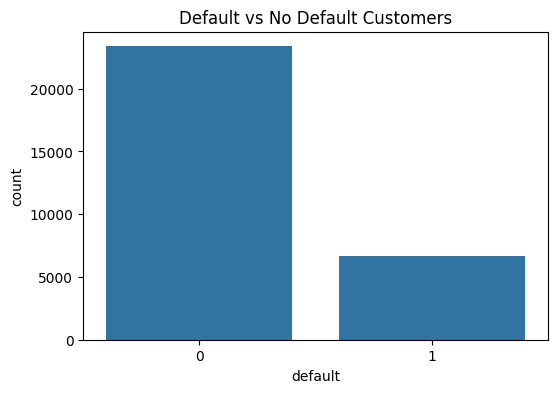

In [11]:
print(df['default'].value_counts())

plt.figure(figsize=(6,4))
sns.countplot(x='default', data=df)
plt.title("Default vs No Default Customers")
plt.show()

In [12]:
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.drop('default')

skew_values = df[num_cols].skew().sort_values(ascending=False)
print("Skewness of Numerical Features:\n", skew_values)

Skewness of Numerical Features:
 PAY_AMT2     30.453817
PAY_AMT3     17.216635
PAY_AMT1     14.668364
PAY_AMT4     12.904985
PAY_AMT5     11.127417
PAY_AMT6     10.640727
BILL_AMT3     3.087830
BILL_AMT5     2.876380
BILL_AMT6     2.846645
BILL_AMT4     2.821965
BILL_AMT2     2.705221
BILL_AMT1     2.663861
PAY_5         1.008197
PAY_4         0.999629
LIMIT_BAL     0.992867
PAY_6         0.948029
PAY_3         0.840682
PAY_2         0.790565
AGE           0.732246
PAY_0         0.731975
EDUCATION     0.489720
MARRIAGE      0.036154
SEX          -0.424183
dtype: float64


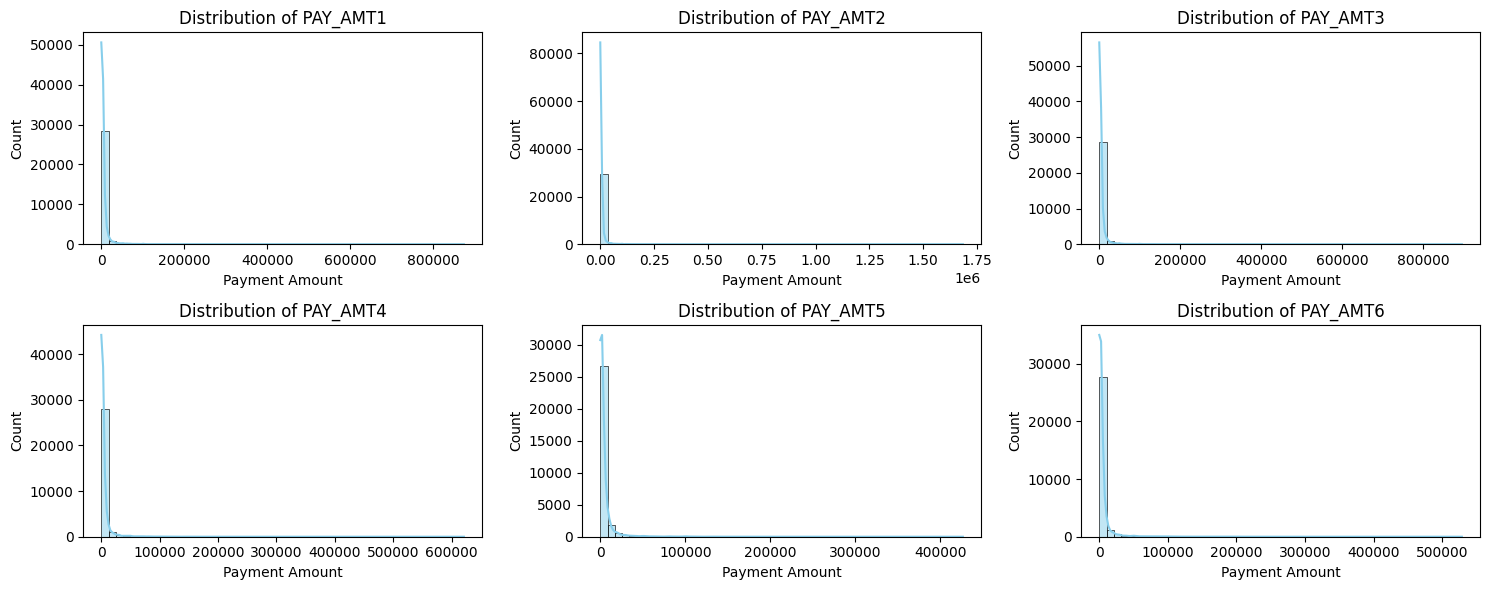

In [13]:
pay_amt_cols = ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

fig, axes = plt.subplots(2, 3, figsize=(15, 6))
axes = axes.flatten()
for i, col in enumerate(pay_amt_cols):
    sns.histplot(df[col], kde=True, ax=axes[i], color='skyblue', bins=50)
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel('Payment Amount')
    axes[i].set_ylabel('Count')
plt.tight_layout()
plt.show()

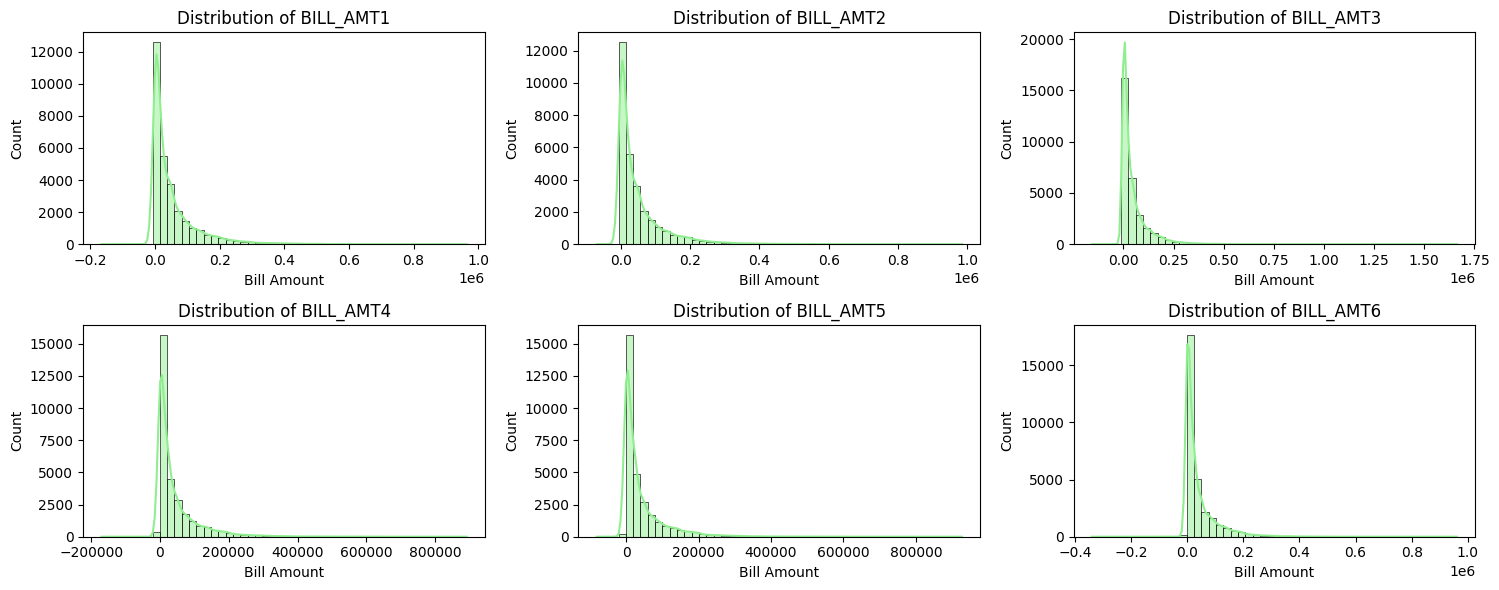

In [14]:
bill_amt_cols = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']

fig, axes = plt.subplots(2, 3, figsize=(15, 6))
axes = axes.flatten()
for i, col in enumerate(bill_amt_cols):
    sns.histplot(df[col], kde=True, ax=axes[i], color='lightgreen', bins=50)
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel('Bill Amount')
    axes[i].set_ylabel('Count')
plt.tight_layout()
plt.show()

In [15]:
num_cols = df.select_dtypes(include=['int64', 'float64']).columns

outlier_summary = {}

for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    outlier_summary[col] = len(outliers)

print("Outlier Count per Column (IQR Method):")
for key, val in outlier_summary.items():
    print(f"{key}  :  {val} outliers")

Outlier Count per Column (IQR Method):
LIMIT_BAL  :  167 outliers
SEX  :  0 outliers
EDUCATION  :  468 outliers
MARRIAGE  :  0 outliers
AGE  :  272 outliers
PAY_0  :  3130 outliers
PAY_2  :  4410 outliers
PAY_3  :  4209 outliers
PAY_4  :  3508 outliers
PAY_5  :  2968 outliers
PAY_6  :  3079 outliers
BILL_AMT1  :  2400 outliers
BILL_AMT2  :  2395 outliers
BILL_AMT3  :  2469 outliers
BILL_AMT4  :  2622 outliers
BILL_AMT5  :  2725 outliers
BILL_AMT6  :  2693 outliers
PAY_AMT1  :  2745 outliers
PAY_AMT2  :  2714 outliers
PAY_AMT3  :  2598 outliers
PAY_AMT4  :  2994 outliers
PAY_AMT5  :  2945 outliers
PAY_AMT6  :  2958 outliers
default  :  6636 outliers


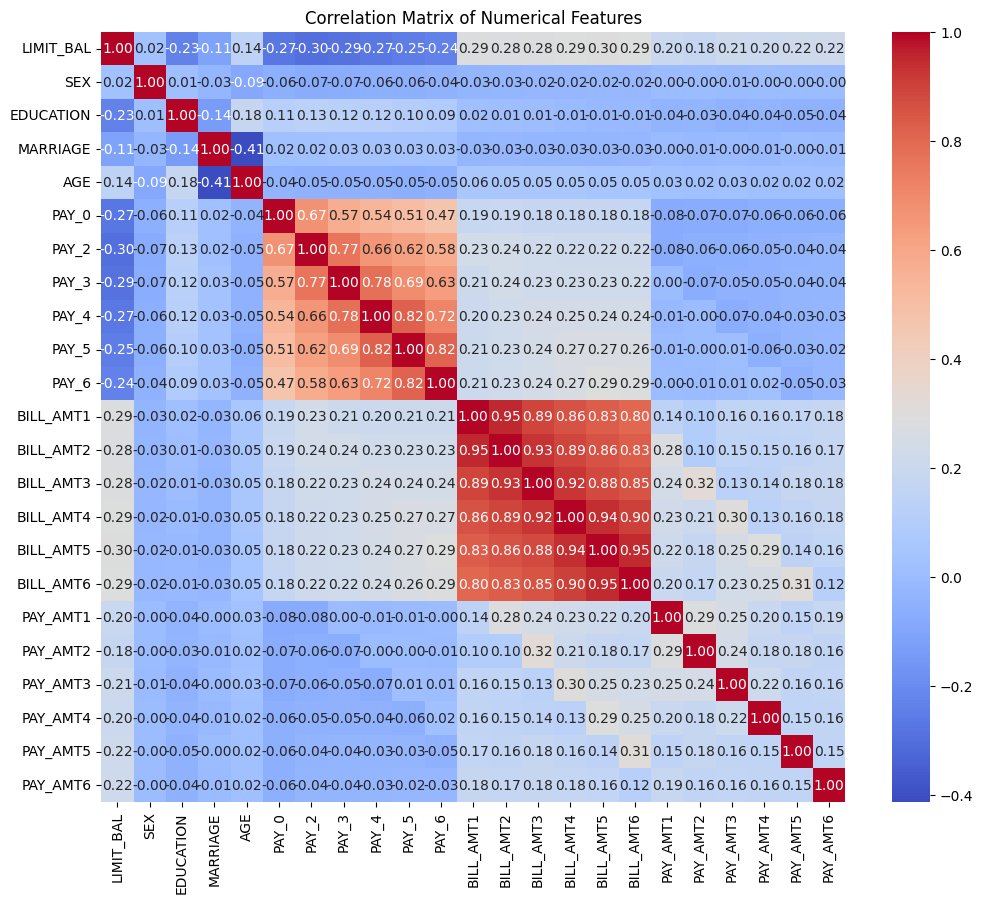

Correlation with target:
 default      1.000000
PAY_0        0.324794
PAY_2        0.263551
PAY_3        0.235253
PAY_4        0.216614
PAY_5        0.204149
PAY_6        0.186866
EDUCATION    0.033842
AGE          0.013890
BILL_AMT6   -0.005372
BILL_AMT5   -0.006760
BILL_AMT4   -0.010156
BILL_AMT3   -0.014076
BILL_AMT2   -0.014193
BILL_AMT1   -0.019644
MARRIAGE    -0.027575
SEX         -0.039961
PAY_AMT6    -0.053183
PAY_AMT5    -0.055124
PAY_AMT3    -0.056250
PAY_AMT4    -0.056827
PAY_AMT2    -0.058579
PAY_AMT1    -0.072929
LIMIT_BAL   -0.153520
Name: default, dtype: float64


In [16]:
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.drop('default')

corr_matrix = df[num_cols].corr()

plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix of Numerical Features")
plt.show()

target_corr = df.corr()['default'].sort_values(ascending=False)
print("Correlation with target:\n", target_corr)

Features and target

In [17]:
X = df.drop('default', axis=1)
y = df['default']

Train-test split

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [19]:
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (24000, 23)
Test shape: (6000, 23)


Handle Class Imbalance — SMOTE

In [20]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

Define Base Estimator & AdaBoost

In [21]:
base_est = DecisionTreeClassifier(max_depth=3, random_state=42)
ada = AdaBoostClassifier(estimator=base_est, n_estimators=100, learning_rate=0.5, random_state=42)

In [22]:
ada.fit(X_train_res, y_train_res)

,estimator,DecisionTreeC...ndom_state=42)
,n_estimators,100
,learning_rate,0.5
,algorithm,'deprecated'
,random_state,42
,criterion,'gini'
,splitter,'best'
,max_depth,3
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0


In [23]:
y_pred = ada.predict(X_test)
y_proba = ada.predict_proba(X_test)[:, 1]

Evaluate on Test Set

In [24]:
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

print("Accuracy:", acc)
print("\nConfusion Matrix:\n", cm)
print("\nROC-AUC Score:", roc_auc)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7475

Confusion Matrix:
 [[3747  926]
 [ 589  738]]

ROC-AUC Score: 0.7345103773203048

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.80      0.83      4673
           1       0.44      0.56      0.49      1327

    accuracy                           0.75      6000
   macro avg       0.65      0.68      0.66      6000
weighted avg       0.77      0.75      0.76      6000



ROC Curve Visualization

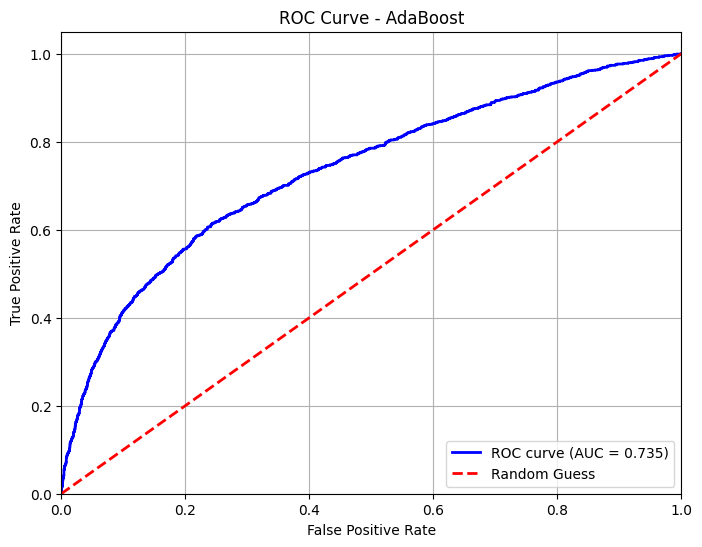

In [25]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - AdaBoost')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()